Сегодня мы поговорим о более крупных моделях, которые уже обучены другими. Такие модели намного более стабильны и их результат может быть релевантнее для решения широких задач. 

Текущий семинар основан на следующей статье Б. В. Орехова: https://habr.com/ru/articles/326380/  
Некоторые ключевые позиции из введения:  
1. В какой-то мере реальное словоупотребление могло бы контрастно оттенить потенциальное, которое можно найти в черновиках писателя. Писатель не сразу вдохновенно пишет свой текст от начала до конца, он мучается, выбирает между вариантами, те, что кажутся ему недостаточно выразительными, он вычеркивает и ищет новые.
2. Черновики есть не для всех текстов, они отрывочны и читать их сложно. Однако можно провести такой эксперимент: заменить все поддающиеся замене слова на похожие, и читать классический текст параллельно с тем, которого никогда не было, но который мог бы возникнуть в какой-то параллельной вселенной.

Здесь мы научимся пользовать готовыми моделями и проведем этот небольшой исследовательский эксперимент. Мы будем пользоваться следующей моделью, подготовленной командой RusVectores (https://rusvectores.org/en/models/):

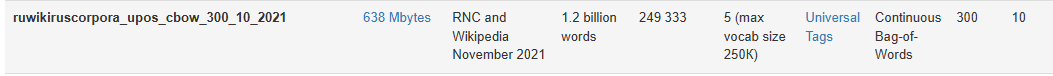

Чтобы реплицировать эксперимент, нам нужно получить ассоциаты/квазисинонимы для создания квазичерновиков. Мы с вами уже такое делали на основании наших небольших самообученных моделей.

In [ ]:
import gensim
from pymorphy3 import MorphAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import os
from tqdm import tqdm
morph = MorphAnalyzer()
stopwords_ru = set(stopwords.words('russian'))
import random

Подгрузим модель из bin-файла.

In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format('model.bin', binary=True)

Проверим, что модель работает корректно:

In [ ]:
print(model.most_similar('запад_NOUN'))

Работает! Теперь сравним, например, результат с И. С.Аксаковым и компанией, а заодно научимся сохранять наши модели, чтобы не обучать их каждый раз заново.

In [ ]:
path = 'Slavs/'
corpus_tagged = []
for filename in tqdm(os.listdir(path)):
    with open(path + filename, encoding='utf-8') as txt:
        text = txt.read()
        text = re.sub(r'\n', ' ', text)
        text = re.sub(r'[^А-Яа-я -]', '', text.lower())
        text = [str(morph.parse(token)[0].normal_form) + '_' + str(morph.parse(token)[0].tag.POS) for token in word_tokenize(text) if token not in stopwords_ru and len(token) > 2]
        corpus_tagged.append(text)
w2v_cbow_tagged = gensim.models.Word2Vec(corpus_tagged, vector_size=300, window=5, min_count=2, sg=0, epochs=5) 

Теперь сохраним обученную модель:

In [ ]:
w2v_cbow_tagged.wv.save_word2vec_format('aksakov_model.bin', binary=True) 

Выше мы сохранили модель в бинарном формате, который заметно компактнее; он удобен для распространения конечных версий моделей. Можно также сохранять более крупные, но при этом доступные к дообучению файлы следующим образом:

In [ ]:
w2v_cbow_tagged.save('aksakov_mod.model')

Такой способ сохраняет не только вектора, но и параметры обучения.

Проверим, что сохраненная модель рабочая:

In [ ]:
model_aks = gensim.models.KeyedVectors.load_word2vec_format('aksakov_model.bin', binary=True)

In [ ]:
print(model_aks.most_similar('запад_NOUN'))
print(model.most_similar('запад_NOUN'))

И сразу видно качественное отличие очень большой модели и нашей скромной.

Перейдем к созданию псевдочерновиков. Начнем с "Евгения Онегина", с которым мы уже много работали.

Для начала просто откроем его:

In [ ]:
with open('EugeneOnegin.txt', encoding='utf-8') as txt:
    text = txt.read()
    text = re.sub(' +', ' ', text) #уберем множественные пробелы, которые используются для отбивки
    print(text[63:445])

In [ ]:
with open('EugeneOnegin.txt', encoding='utf-8') as txt:
    text = txt.read()
    text = re.sub(' +', ' ', text) #уберем множественные пробелы, которые используются для отбивки
    text = text[63:445]
    lines = text.split('\n')
    lines_prep = []
    for line in lines:
        lines_prep.append(' '.join(['_'.join([str(morph.parse(token)[0].normal_form), str(morph.parse(token)[0].tag.POS)]) for token in word_tokenize(line)]))
   # text = ' '.join(['_'.join([str(morph.parse(token)[0].normal_form), str(morph.parse(token)[0].tag.POS)]) for token in word_tokenize(text)])

Отлично, мы получили первую строфу в начальной форме. 

In [ ]:
lines_prep

Теперь надо заменить все возможное на ближайшие ассоциаты. Не имеет смысла менять служебные слова. Пойдем по частям речи. Начнем с существительных и просто посмотрим, что там происходит:

In [ ]:
for line in lines_prep:
    for token in line.split():
        if token[-4:] == 'NOUN':
            print(f'{token} из "Евгения Онегина" = {model.most_similar(token)[0][0]} "из векторной модели"')

Теперь проведем замены:

In [ ]:
new_nouns_eug = []
for line in lines_prep:
    line_change = []
    for token in line.split():
        if token[-4:] == 'NOUN':
            line_change.append(model.most_similar(token)[0][0][:-5])
        else:
            line_change.append(token[:-5])
    new_nouns_eug.append(' '.join(line_change))

In [ ]:
text_new = '\n'.join(new_nouns_eug)
text_new = re.sub('_', '', text_new)
text_new = re.sub(r'\s+([.,!?;:])', r'\1', text_new) #уберем пробелы
print(text_new)

Восстановим падежные формы. Pymorphy умеет восстанавливать формы с помощью inflect. У нас есть следующие падежи:
1. **nomn**,
2.  **gent**,
3.  **datv**,
4.  **accs**,
5.  **ablt**,
6.  **loct**.

Получается это не самым простым образом:

In [ ]:
morph.parse('племянник')[0].inflect({'accs'}).word

Соберем по оригинальному тексту нужную нам грамматическую информацию:

In [ ]:
nouns_cases = []
for token in word_tokenize(text):
    tok_parse = morph.parse(token)[0]
    if tok_parse.tag.POS == 'NOUN':
        nouns_cases.append(tok_parse.tag.case)
print(nouns_cases)

In [ ]:
counter = 0
ind = 0
new_text_cased_lst = []
for line in text_new.split('\n'):
    new_line = []
    for token in word_tokenize(line):
        if morph.parse(token)[0].tag.POS == 'NOUN':
            print(nouns_cases[counter])
            new_line.append(morph.parse(token)[0].inflect({nouns_cases[counter]}).word)
            counter += 1
            ind += 1
        else:
            new_line.append(word_tokenize(text)[ind])
            ind += 1
    new_text_cased_lst.append(' '.join(new_line))

Насладимся результатом (нам явно не хватило падежей, отсюда ошибка выше):

In [ ]:
new_text_cased = '\n'.join(new_text_cased_lst)
new_text_cased = re.sub(r'\s+([.,!?;:])', r'\1', new_text_cased) 
print(new_text_cased)

Теперь, когда понятен общий принцип, объединим все вместе и оптимизируем алгоритм:

In [ ]:
with open('EugeneOnegin.txt', encoding='utf-8') as txt:
    text = txt.read()
    text = re.sub(' +', ' ', text) 
    text = text[63:445]
    lines = text.split('\n')
    lines_prep = []
    for line in lines:
        new_line = []
        for token in word_tokenize(line):
            parse_tok = morph.parse(token)[0]
            if parse_tok.tag.POS == 'NOUN':
                case = parse_tok.tag.case
                number = parse_tok.tag.number
                new_noun = model.most_similar('_'.join([parse_tok.normal_form, 'NOUN']))[0][0]
                new_noun = re.sub('_[A-Z]+', '', new_noun)
                new_line.append(morph.parse(new_noun)[0].inflect({case, number}).word)
            else:
                new_line.append(token)
        lines_prep.append(' '.join(new_line))
    final_strophe = '\n'.join(lines_prep)
    final_strophe = re.sub(r'\s+([.,!?;:])', r'\1', final_strophe) 
    print(final_strophe)

Уже неплохо! Но нам нужно защититься от замен не на ту часть речи, если таковая случится. Для этого нам нужно брать некоторое количество топовых сходств, а не первое, а затем фильтровать. Поменяем чуть-чуть код:

In [ ]:
with open('EugeneOnegin.txt', encoding='utf-8') as txt:
    text = txt.read()
    text = re.sub(' +', ' ', text) 
    text = text[63:445]
    lines = text.split('\n')
    lines_prep = []
    for line in lines:
        new_line = []
        for token in word_tokenize(line):
            parse_tok = morph.parse(token)[0]
            if parse_tok.tag.POS == 'NOUN':
                case = parse_tok.tag.case
                number = parse_tok.tag.number
                similar_words = model.most_similar('_'.join([parse_tok.normal_form, 'NOUN']), topn=10)
                for sim_word in similar_words:
                    if sim_word[0][-4:] == 'NOUN':
                        new_noun = re.sub('_[A-Z]+', '', sim_word[0])
                        new_line.append(morph.parse(new_noun)[0].inflect({case, number}).word)
                        break
                    else:
                        continue

            else:
                new_line.append(token)
        lines_prep.append(' '.join(new_line))
    final_strophe = '\n'.join(lines_prep)
    final_strophe = re.sub(r'\s+([.,!?;:])', r'\1', final_strophe) 
    print(final_strophe)

Остались нюансы в виде согласования. Можно, конечно, контролировать зависимые прилагательные (желающие могут рискнуть написать такой код), но пока просто добавим контроль, чтобы существительное было того же рода:

In [ ]:
with open('EugeneOnegin.txt', encoding='utf-8') as txt:
    text = txt.read()
    text = re.sub(' +', ' ', text) 
    text = text[63:445]
    lines = text.split('\n')
    lines_prep = []
    for line in lines:
        new_line = []
        for token in word_tokenize(line):
            parse_tok = morph.parse(token)[0]
            if parse_tok.tag.POS == 'NOUN':
                case = parse_tok.tag.case
                number = parse_tok.tag.number
                gender = parse_tok.tag.gender
                similar_words = model.most_similar('_'.join([parse_tok.normal_form, 'NOUN']), topn=100)
                for sim_word in similar_words:
                    if sim_word[0][-4:] == 'NOUN' and morph.parse(sim_word[0][:-5])[0].tag.gender == gender:
                        new_noun = re.sub('_[A-Z]+', '', sim_word[0])
                        new_line.append(morph.parse(new_noun)[0].inflect({case, number}).word)
                        break
                    else:
                        continue

            else:
                new_line.append(token)
        lines_prep.append(' '.join(new_line))
    final_strophe = '\n'.join(lines_prep)
    final_strophe = re.sub(r'\s+([.,!?;:])', r'\1', final_strophe) 
    print(final_strophe)

Посмотрим на сон Татьяны:

In [ ]:
dream = '''И страшно ей; и торопливо
Татьяна силится бежать:
Нельзя никак; нетерпеливо
Метаясь, хочет закричать:
Не может; дверь толкнул Евгений:
И взорам адских привидений
Явилась дева; ярый смех
Раздался дико; очи всех,
Копыты, хоботы кривые,
Хвосты хохлатые, клыки,
Усы, кровавы языки,
Рога и пальцы костяные,
Всё указует на нее,
И все кричат: мое! мое!
'''


text = dream
text = re.sub(' +', ' ', text) 
text = text[63:445]
lines = text.split('\n')
lines_prep = []
for line in lines:
    new_line = []
    for token in word_tokenize(line):
        parse_tok = morph.parse(token)[0]
        if parse_tok.tag.POS == 'NOUN':
            case = parse_tok.tag.case
            number = parse_tok.tag.number
            gender = parse_tok.tag.gender
            similar_words = model.most_similar('_'.join([parse_tok.normal_form, 'NOUN']), topn=100)
            for sim_word in similar_words:
                if sim_word[0][-4:] == 'NOUN' and morph.parse(sim_word[0][:-5])[0].tag.gender == gender:
                    new_noun = re.sub('_[A-Z]+', '', sim_word[0])
                    new_line.append(morph.parse(new_noun)[0].inflect({case, number}).word)
                    break
                else:
                    continue

        else:
            new_line.append(token)
    lines_prep.append(' '.join(new_line))
final_strophe = '\n'.join(lines_prep)
final_strophe = re.sub(r'\s+([.,!?;:])', r'\1', final_strophe) 
print(final_strophe)

Мы столкнулись с ошибкой, так что добавим исключения:

In [ ]:
dream = '''И страшно ей; и торопливо
Татьяна силится бежать:
Нельзя никак; нетерпеливо
Метаясь, хочет закричать:
Не может; дверь толкнул Евгений:
И взорам адских привидений
Явилась дева; ярый смех
Раздался дико; очи всех,
Копыты, хоботы кривые,
Хвосты хохлатые, клыки,
Усы, кровавы языки,
Рога и пальцы костяные,
Всё указует на нее,
И все кричат: мое! мое!
'''

text = dream
lines = text.split('\n')
lines_prep = []
for line in lines:
    new_line = []
    for token in word_tokenize(line):
        parse_tok = morph.parse(token)[0]
        if parse_tok.tag.POS == 'NOUN':
            case = parse_tok.tag.case
            number = parse_tok.tag.number
            gender = parse_tok.tag.gender
            try:
                similar_words = model.most_similar('_'.join([parse_tok.normal_form, 'NOUN']), topn=100)
                for sim_word in similar_words:
                    if sim_word[0][-4:] == 'NOUN' and morph.parse(sim_word[0][:-5])[0].tag.gender == gender:
                        new_noun = re.sub('_[A-Z]+', '', sim_word[0])
                        new_line.append(morph.parse(new_noun)[0].inflect({case, number}).word)
                        break
                    else:
                        continue
            except KeyError:
                    new_noun = parse_tok.inflect({case, number}).word
                    new_line.append(new_noun)

        else:
            new_line.append(token)
    lines_prep.append(' '.join(new_line))
final_strophe = '\n'.join(lines_prep)
final_strophe = re.sub(r'\s+([.,!?;:])', r'\1', final_strophe) 
print(final_strophe)

**Задание 1**. Возьмите любые пять  русских пословиц и замените в них существительные. Что получится?  
Можно взять здесь: https://ru.wikiquote.org/wiki/%D0%A0%D1%83%D1%81%D1%81%D0%BA%D0%B8%D0%B5_%D0%BF%D0%BE%D1%81%D0%BB%D0%BE%D0%B2%D0%B8%D1%86%D1%8B 

In [ ]:
#ваш код здесь

Теперь поработаем с прилагательными: с ними работать приятно, т.к. набор тэгов совпадает с существительными.

In [ ]:
with open('EugeneOnegin.txt', encoding='utf-8') as txt:
    text = txt.read()
    text = re.sub(' +', ' ', text) 
    text = text[63:445]
    lines = text.split('\n')
lines_prep = []
for line in lines:
    new_line = []
    for token in word_tokenize(line):
        parse_tok = morph.parse(token)[0]
        if parse_tok.tag.POS in ['ADJF', 'ADJS']:
            case = parse_tok.tag.case or 'nomn'
            number = parse_tok.tag.number or random.choice(['sing', 'plur'])
            gender = parse_tok.tag.gender or random.choice(['neut', 'femn', 'masc'])
            tok_for_model = '_'.join([parse_tok.normal_form, 'ADJ'])
            if tok_for_model in model:
                similar_words = model.most_similar(tok_for_model, topn=10)
                for sim_word in similar_words:
                    if sim_word[0][-3:] == 'ADJ':
                        new_adj = re.sub('_[A-Z]+', '', sim_word[0])
                        infl = morph.parse(new_adj)[0].inflect({case, number, gender})
                        if infl:
                            new_line.append(infl.word)
                        else:
                            new_line.append(parse_tok.word)
                        break 


                else:
                    infl = parse_tok.inflect({case, number, gender})
                    new_line.append(infl.word if infl else parse_tok.word)

        else:
            new_line.append(parse_tok.word)


    
    lines_prep.append(' '.join(new_line))


   
final_strophe = '\n'.join(lines_prep)
final_strophe = re.sub(r'\s+([.,!?;:])', r'\1', final_strophe) 
print(final_strophe)

In [ ]:
text = '''И страшно ей; и торопливо
Татьяна силится бежать:
Нельзя никак; нетерпеливо
Метаясь, хочет закричать:
Не может; дверь толкнул Евгений:
И взорам адских привидений
Явилась дева; ярый смех
Раздался дико; очи всех,
Копыты, хоботы кривые,
Хвосты хохлатые, клыки,
Усы, кровавы языки,
Рога и пальцы костяные,
Всё указует на нее,
И все кричат: мое! мое!
'''
lines = text.split('\n')
lines_prep = []
for line in lines:
    new_line = []
    for token in word_tokenize(line):
        parse_tok = morph.parse(token)[0]
        if parse_tok.tag.POS in ['ADJF', 'ADJS']:
            case = parse_tok.tag.case or 'nomn'
            number = parse_tok.tag.number or random.choice(['sing', 'plur'])
            gender = parse_tok.tag.gender or random.choice(['neut', 'femn', 'masc'])
            tok_for_model = '_'.join([parse_tok.normal_form, 'ADJ'])
            if tok_for_model in model:
                similar_words = model.most_similar(tok_for_model, topn=10)
                for sim_word in similar_words:
                    if sim_word[0][-3:] == 'ADJ':
                        new_adj = re.sub('_[A-Z]+', '', sim_word[0])
                        infl = morph.parse(new_adj)[0].inflect({case, number, gender})
                        if infl:
                            new_line.append(infl.word)
                        else:
                            new_line.append(parse_tok.word)
                        break 

                else:
                    infl = parse_tok.inflect({case, number, gender})
                    new_line.append(infl.word if infl else parse_tok.word)

        else:
            new_line.append(parse_tok.word)


    
    lines_prep.append(' '.join(new_line))


   
final_strophe = '\n'.join(lines_prep)
final_strophe = re.sub(r'\s+([.,!?;:])', r'\1', final_strophe) 
print(final_strophe)

Теперь наречия, что ещё легче:

In [ ]:
dream = '''И страшно ей; и торопливо
Татьяна силится бежать:
Нельзя никак; нетерпеливо
Метаясь, хочет закричать:
Не может; дверь толкнул Евгений:
И взорам адских привидений
Явилась дева; ярый смех
Раздался дико; очи всех,
Копыты, хоботы кривые,
Хвосты хохлатые, клыки,
Усы, кровавы языки,
Рога и пальцы костяные,
Всё указует на нее,
И все кричат: мое! мое!
'''

text = dream
text = re.sub(' +', ' ', text) 
lines = text.split('\n')
lines_prep = []
for line in lines:
    new_line = []
    for token in word_tokenize(line):
        parse_tok = morph.parse(token)[0]
        if parse_tok.tag.POS == 'ADVB':
            try:
                similar_words = model.most_similar('_'.join([parse_tok.normal_form, 'ADV']), topn=5)
                
                for sim_word in similar_words:

                    if sim_word[0][-3:] == 'ADV':
                        new_adv = re.sub('_[A-Z]+', '', sim_word[0])
                        new_line.append(new_adv)
                        break
            except KeyError:
                    new_adv = parse_tok.word
                    new_line.append(new_adv)
        else:
            new_line.append(token)    
    lines_prep.append(' '.join(new_line))
    
final_strophe = '\n'.join(lines_prep)
final_strophe = re.sub(r'\s+([.,!?;:])', r'\1', final_strophe) 
print(final_strophe)

И закончим глаголами:

In [ ]:
text = dream
text = re.sub(' +', ' ', text) 
lines = text.split('\n')
lines_prep = []
for line in lines:
    new_line = []
    for token in word_tokenize(line):
        parse_tok = morph.parse(token)[0]
        tense = parse_tok.tag.tense
        person = parse_tok.tag.person
        if parse_tok.tag.POS in ['VERB', 'INFN']:
            try:
                sim_verbs = model.most_similar('_'.join([parse_tok.normal_form, 'VERB']), topn=5)
                for sim_verb in sim_verbs:
                    if sim_verb[0][-4:] == 'VERB':
                        new_verb = re.sub('_[A-Z]+', '', sim_verb[0])
                        inflect_tags = {'INFN'} if parse_tok.tag.POS == 'INFN' else set()
                        if tense and parse_tok.tag.POS != 'INFN':
                            inflect_tags.add(tense)
                        if person and parse_tok.tag.POS != 'INFN':
                            inflect_tags.add(person)
                        inflected = morph.parse(new_verb)[0].inflect(inflect_tags)
                        verb_infl = inflected.word if inflected else new_verb
                        new_line.append(verb_infl)
                        break
                else:
                    new_line.append(parse_tok.word)
            except KeyError:
                new_line.append(parse_tok.word)
        else:
            new_line.append(parse_tok.word)
    lines_prep.append(' '.join(new_line))
final_strophe = '\n'.join(lines_prep) 
final_strophe = re.sub(r'\s+([.,!?;:])', r'\1', final_strophe) 
print(final_strophe)

Осталось только написать мегафункцию, которая "испортит" все части речи. Сделаем же это.  
**Задание 2**. Попробуйте объединить весь код так, чтобы получилась единая функция для всех частей речи.

In [ ]:
def strophe_changer(text):
    return final_strophe

In [ ]:
text = '''И страшно ей; и торопливо
Татьяна силится бежать:
Нельзя никак; нетерпеливо
Метаясь, хочет закричать:
Не может; дверь толкнул Евгений:
И взорам адских привидений
Явилась дева; ярый смех
Раздался дико; очи всех,
Копыты, хоботы кривые,
Хвосты хохлатые, клыки,
Усы, кровавы языки,
Рога и пальцы костяные,
Всё указует на нее,
И все кричат: мое! мое!
'''
print(strophe_changer(text))

**Задание 3.** Перепешите на основании всего того, что есть выше, "Анну Каренину" так, как будто её написал Ф. М. Достоевский (или любой другой автор на ваше усмотрение). Обучите модель на основании предложенного корпуса Достоевского.